Logbook:
https://docs.google.com/document/d/10F1qXnhcWOobazE5PRGmF3VUbtTOQDvJnlBE9xEdjEs/edit

# imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from glob import glob
from os.path import basename, exists
from tiffile import imread
import laserbeamsize as lbs
import matplotlib as mpl
import re
import xarray as xr
import h5py
import dask.array as da
import dask.dataframe as dd
from nexus import NexusReader
mpl.rcParams['font.size'] = 20

# Load data

In [2]:
folder = r"G:\.shortcut-targets-by-id\1YpiqDkNOTGtSG67X3m1KkAOsZ3lZoC5i\Cosmic Scattering Endstation 7.0.1.1\Data\Tumbleson\pcmo_3-17-2023/pcmo_3-23-2023/"
files = sorted(glob(folder+'*tif'))
for i, f in enumerate(files):
    print(i, basename(f))

0 xpcs_200K 2023 March 23 07_09_46 271.tif
1 xpcs_225K 2023 March 23 11_14_44 272.tif
2 xpcs_230K 2023 March 23 15_03_15 273.tif
3 xpcs_230_5K 2023 March 23 18_09_25 274.tif
4 xpcs_231K 2023 March 23 21_13_38 275.tif
5 xpcs_231_1K 2023 March 24 00_16_07 276.tif
6 xpcs_231_5K 2023 March 24 03_49_57 277.tif
7 xpcs_232K_no_wait 2023 March 24 06_08_05 278.tif


In [14]:
temps = []
for f in files:
    b = basename(f)
    tmp = re.findall("\d+", basename(f))
    if tmp[1] != '2023':
        temps.append(float(tmp[0]+'.'+tmp[1]))
    else:
        temps.append(float(tmp[0]))
        
temps, files = zip(*sorted(zip(temps, files)))

In [4]:
temps

(200.0, 225.0, 230.0, 230.5, 231.0, 231.1, 231.5, 232.0)

In [15]:
datasets = []
for temp, file in tqdm(zip(temps, files), total=len(files)):
    out_file = f'../data/{temp}K.h5'
    if exists(out_file):
        continue
    store = imread(file, aszarr=True)
    ds = xr.Dataset(
        data_vars={'image_stack': (('time', 'row', 'col'), da.from_zarr(store))},
        coords={
            'time': np.arange(da.from_zarr(store).shape[0]),
            'row': np.arange(da.from_zarr(store).shape[1]),
            'col': np.arange(da.from_zarr(store).shape[2]),
        },
        attrs=dict(temperature=temp)
    )
    ds.to_netcdf(out_file, engine='h5netcdf')

  0%|          | 0/8 [00:00<?, ?it/s]

In [16]:
ds

<xarray.Dataset>
Dimensions:      (time: 2005, row: 1340, col: 1300)
Coordinates:
  * time         (time) int32 0 1 2 3 4 5 6 ... 1999 2000 2001 2002 2003 2004
  * row          (row) int32 0 1 2 3 4 5 6 ... 1334 1335 1336 1337 1338 1339
  * col          (col) int32 0 1 2 3 4 5 6 ... 1294 1295 1296 1297 1298 1299
Data variables:
    image_stack  (time, row, col) float32 dask.array<chunksize=(1, 4, 1300), meta=np.ndarray>
Attributes:
    temperature:  231.5

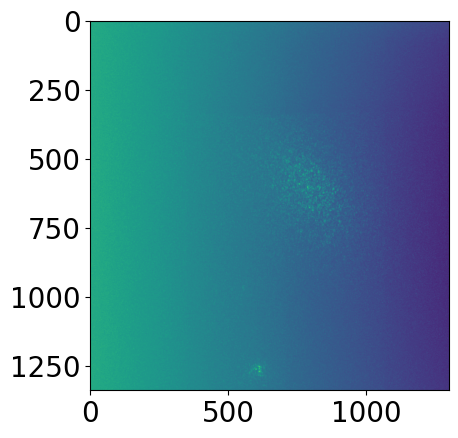

In [19]:
plt.imshow(ds['image_stack'][0])

In [8]:
ds.min().compute()

<xarray.Dataset>
Dimensions:      ()
Data variables:
    image_stack  float32 -3.386e+38

# check

In [5]:
ds = xr.open_dataset(r'G:\Shared drives\code\projects\pcmo\data\232K.h5')

ValueError: did not find a match in any of xarray's currently installed IO backends ['h5netcdf', 'scipy', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

In [11]:
ds

<xarray.Dataset>
Dimensions:      (time: 2401, row: 1340, col: 1300)
Coordinates:
  * time         (time) int32 0 1 2 3 4 5 6 ... 2395 2396 2397 2398 2399 2400
  * row          (row) int32 0 1 2 3 4 5 6 ... 1334 1335 1336 1337 1338 1339
  * col          (col) int32 0 1 2 3 4 5 6 ... 1294 1295 1296 1297 1298 1299
Data variables:
    image_stack  (time, row, col) float32 ...
Attributes:
    temperature:  231.1